In [ ]:
!pip install tensorflow pandas scikit-learn

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_columns',None)

In [ ]:
def call_rmsle(y_true, y_pred):
    # Ensure predictions and true values are positive by adding 1
    y_true = tf.math.maximum(y_true, 0)
    y_pred = tf.math.maximum(y_pred, 0)

    # Compute the logarithm of the true and predicted values
    log_true = tf.math.log1p(y_true)
    log_pred = tf.math.log1p(y_pred)

    # Compute the squared difference
    squared_diff = tf.math.square(log_true - log_pred)

    # Compute the mean of the squared differences
    mean_squared_diff = tf.math.reduce_mean(squared_diff)

    # Return the square root of the mean squared differences
    return tf.math.sqrt(mean_squared_diff)

def remove_leading_zeros(df):
    # Find the index of the first non-zero sales value
    first_non_zero_index = df['sales'].ne(0).idxmax()

    # Filter the DataFrame to remove leading zeros
    return df.loc[first_non_zero_index:]

In [ ]:
df_train_all    = pd.read_csv('data/SPX.csv')

In [ ]:
df_train_all.tail()

In [ ]:
df_train_all['10DMA'] =  df_train_all['Adj Close'].rolling(window=10).mean()
df_train_all['30DMA'] =  df_train_all['Adj Close'].rolling(window=30).mean()
df_train_all['100DMA'] =  df_train_all['Adj Close'].rolling(window=100).mean()


In [ ]:
df_train_all.dropna(subset=['100DMA'], inplace=True)


In [ ]:
import calendar
from datetime import datetime, timedelta
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0




In [ ]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'])

df_train_all['day'] = df_train_all['Date'].dt.day
df_train_all['month'] = df_train_all['Date'].dt.month
df_train_all['year'] = df_train_all['Date'].dt.year

df_train_all['opt_exp'] = df_train_all['Date'].apply(is_last_thursday)

In [ ]:
df_train_all['year'] = df_train_all['year'] - df_train_all['year'].min()


# Convert month and day to cyclical features
#df_train_all['month_sin'] = np.sin(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['month_cos'] = np.cos(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['day_sin'] = np.sin(2 * np.pi * df_train_all['day'] / 31)
#df_train_all['day_cos'] = np.cos(2 * np.pi * df_train_all['day'] / 31)



In [ ]:
#df_train_all['price_next'] = df_train_all['Close'].shift(-1)
df_train_all['pct_change'] = df_train_all['Close']/df_train_all['Open']  
df_train_all['prev_close'] = df_train_all['Close'].shift(1)
df_train_all['opening_gap'] = df_train_all['Open'] - df_train_all['prev_close'] 
df_train_all['daily_move'] = df_train_all['High'] - df_train_all['Low']
df_train_all['daily_move']= df_train_all['daily_move'].shift(1) #previous day daily movement
df_train_all['daily_move_avg'] =  df_train_all['daily_move'].rolling(window=1).mean() #average of last 5 day movement
#df_train_all['price_lag2'] = df_train_all['Adj Close'].shift(2)
#df_train_all['price_lag3'] = df_train_all['Adj Close'].shift(3)
#df_train_all['price_lag4'] = df_train_all['Adj Close'].shift(4)
#df_train_all['price_lag5'] = df_train_all['Adj Close'].shift(5)

In [ ]:
#df_train_all.dropna(subset=['price_lag5'], inplace=True)

In [ ]:
df_train_all.head(10)

In [ ]:
df_train_all.drop(['High','Low','Adj Close','daily_move','prev_close'],axis =1, inplace = True) 

In [ ]:
df_train_all.tail()

In [ ]:
df_train_all.dropna(subset=['daily_move_avg'], inplace=True)


In [ ]:
# df = df_train_all.copy()

In [ ]:
# # Create lists to hold the new columns
# dates = []
# price_type = []
# prices = []

# # Populate the lists using iloc
# for i in range(len(df)):
#     dates.append(df.iloc[i]['Date'])
#     price_type.append('Open')
#     prices.append(df.iloc[i]['Open'])
    
#     dates.append(df.iloc[i]['Date'])
#     price_type.append('Close')
#     prices.append(df.iloc[i]['Close'])

# # Creating a new DataFrame with the desired format
# new_df = pd.DataFrame({
#     'Date': dates,
#     'Type': price_type,
#     'Price': prices
# })

# # Showing the result
# print(new_df.head())


In [ ]:
df_train = df_train_all[df_train_all['Date']<=  '2023-08-23'] #keeping 4 years for training 
df_test  = df_train_all[df_train_all['Date']>  '2023-08-23'] #keeping last year for testing

In [ ]:
df_rnnresults  = pd.DataFrame()

In [ ]:
df_test.tail()

In [53]:
          
df = df_train.copy()
df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################

# Features to be scaled
features_to_scale = ['Open', 'Close','Volume','10DMA','year','day','month','opening_gap','daily_move_avg']
#features_to_scale = ['Open', 'Close','Volume','10DMA','30DMA','100DMA','opening_gap','daily_move_avg']

# Features to be left unscaled (those ending with 'sin' or 'cos')
#features_to_leave = ['opt_exp','month_sin','month_cos','day_sin','day_cos' ]
features_to_leave = ['opt_exp' ]

features = features_to_scale + features_to_leave
#target = 'price_next'
target = 'pct_change'

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the selected features
X_train_scaled_part = feature_scaler.fit_transform(X_train[features_to_scale])
X_test_scaled_part = feature_scaler.transform(X_test[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_train_scaled = np.hstack((X_train_scaled_part, X_train[features_to_leave].values))
X_test_scaled = np.hstack((X_test_scaled_part, X_test[features_to_leave].values))

# Scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))


# Reshape data to fit RNN input shape (num_samples, timesteps, num_features)
timesteps = 1  # You need to define this based on your data and model requirements
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))



In [54]:

# # Build your LSTM model
# model = Sequential()
# model.add(LSTM(256, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(256))
# model.add(Dropout(0.2))
# #model.add(LSTM(256))
# #model.add(Dropout(0.2))

# model.add(Dense(1))

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Compile the model with RMSLE as the loss function
# optimizer = Adam(learning_rate=0.01)
# model.compile(optimizer=optimizer, loss=call_rmsle )

# # Train the model
# history = model.fit(X_train_reshaped, y_train_scaled, epochs=100, 
#                     validation_data=(X_test_reshaped, y_test_scaled), batch_size=64,callbacks=[early_stopping])


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build your RNN model
model = Sequential()
model.add(SimpleRNN(8, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(8))
model.add(Dropout(0.2))
model.add(Dense(8,activation = 'relu'))
model.add(Dense(1))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with RMSLE as the loss function
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=call_rmsle)

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=100, 
                    validation_data=(X_test_reshaped, y_test_scaled), batch_size=8, 
                    callbacks=[early_stopping])

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1344 - val_loss: 0.0587
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0708 - val_loss: 0.0573
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0719 - val_loss: 0.0520
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0672 - val_loss: 0.0438
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0657 - val_loss: 0.0504
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0621 - val_loss: 0.0487
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0658 - val_loss: 0.0631
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0655 - val_loss: 0.0455
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0660 - val_loss: 0.0524


In [63]:

##############################################################################################
#########################          Make Predictions              #############################
##############################################################################################


# Predictions
rnn_predictions = model.predict(X_test_reshaped)

# Ensure both predictions and actual values are of type float64
y_test_scaled = y_test_scaled.reshape(-1, 1).astype('float64')
rnn_predictions_scaled = rnn_predictions.astype('float64')

# Calculate RMSLE
rnn_rmsle_val = call_rmsle(y_test_scaled, rnn_predictions_scaled)

y_test_actual = target_scaler.inverse_transform(y_test_scaled).astype('float64')
rnn_predictions_actual = target_scaler.inverse_transform(rnn_predictions_scaled).astype('float64')
rnn_rmsle_val_actual = call_rmsle(y_test_actual, rnn_predictions_actual)
print("RSMLE we got is ",rnn_rmsle_val_actual)

#

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
RSMLE we got is  tf.Tensor(0.003864768084774516, shape=(), dtype=float64)


## Applying model on Test Data

In [64]:
#############################################################################################
#########################             Applying model on test data       ######################
##############################################################################################

del df
df   = df_test.copy()

df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################


# Scale only the selected features
X_test_scaled_part = feature_scaler.transform(df[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_test_scaled = np.hstack((X_test_scaled_part, df[features_to_leave].values))

X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

# Predictions
rnn_predictions = model.predict(X_test_reshaped)
rnn_predictions_scaled = rnn_predictions.astype('float64')

rnn_predictions_actual = target_scaler.inverse_transform(rnn_predictions_scaled).astype('float64')

# Add predictions to the dataframe
df_test['pct_change_predicted'] = rnn_predictions_actual



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Monil\AppData\Local\Temp\ipykernel_39552\2610052834.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pct_change_predicted'] = rnn_predictions_actual


In [65]:
#df_test['predicted_price_tomorrow'] = df_test['pct_change_predicted']*df_test['Close']
#df_test['predicted_price_today'] = df_test['predicted_price_tomorrow'].shift(1)
df_test['predicted_close'] = df_test['Open']*df_test['pct_change_predicted']

C:\Users\Monil\AppData\Local\Temp\ipykernel_39552\3203385979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_close'] = df_test['Open']*df_test['pct_change_predicted']


In [48]:
df_test.head(100)

,Date,Open,Close,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,pct_change,opening_gap,daily_move_avg,pct_change_predicted,predicted_close
1007,2023-08-24,4455.160156,4376.310059,3723470000,4413.566943,4492.587988,4310.980989,24,8,3,0,0.982301,19.150390,46.740235,1.000053,4455.397751
1008,2023-08-25,4389.379883,4405.709961,3296180000,4407.732959,4489.264323,4313.792991,25,8,3,0,1.003720,13.069824,82.750000,1.000046,4389.580543
1009,2023-08-28,4426.029785,4433.310059,2957230000,4402.091943,4486.281657,4317.120090,28,8,3,0,1.001645,20.319824,62.169922,1.000046,4426.235222
1010,2023-08-29,4432.750000,4497.629883,3354820000,4408.068946,4484.369987,4321.192590,29,8,3,0,1.014636,-0.560059,24.580079,0.999971,4432.619425
1011,2023-08-30,4500.339844,4514.870117,3064110000,4419.122949,4482.674984,4325.291091,30,8,3,0,1.003229,2.709961,68.459961,0.999944,4500.086412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,2024-01-10,4759.939941,4783.450195,3498680000,4747.181104,4683.711686,4469.366606,10,1,4,0,1.004939,3.439941,35.120117,1.000443,4762.049953
1103,2024-01-11,4792.129883,4780.240234,3759890000,4747.047119,4691.223356,4473.471909,11,1,4,0,0.997519,8.679688,34.599610,1.000443,4794.254164
1104,2024-01-12,4791.180176,4783.830078,3486340000,4747.095117,4698.998356,4477.312510,12,1,4,0,0.998466,10.939942,58.919922,1.000443,4793.304036
1105,2024-01-16,4772.350098,4765.979980,4260550000,4746.710107,4705.604362,4481.096812,16,1,4,0,0.998665,-11.479980,33.419922,1.000443,4774.465611


In [66]:
df_test.dropna(subset=['predicted_close'], inplace=True)

C:\Users\Monil\AppData\Local\Temp\ipykernel_39552\3938800536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(subset=['predicted_close'], inplace=True)


In [50]:
df_test[['Close','predicted_close']]

,Close,predicted_close
1007,4376.310059,4455.397751
1008,4405.709961,4389.580543
1009,4433.310059,4426.235222
1010,4497.629883,4432.619425
1011,4514.870117,4500.086412
...,...,...
1254,5608.250000,5558.939931
1255,5597.120117,5604.165537
1256,5620.850098,5604.515558
1257,5570.640137,5639.121966


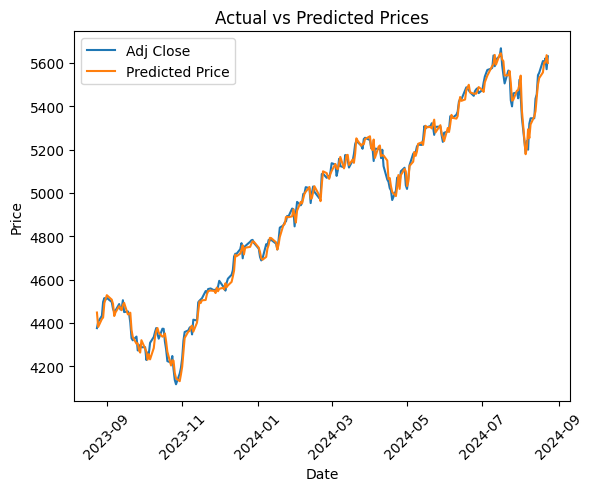

In [67]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test['Date'], df_test['Close'], label='Adj Close')
plt.plot(df_test['Date'], df_test['predicted_close'], label='Predicted Price')

# Add a title, labels, and legend
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()